# Notebook de an√°lise explorat√≥ria dos dados (EDA)

## Importa√ß√£o das bibliotecas

In [1]:
# Libs b√°sicas
import pandas as pd
import numpy as np

# Libs Estat√≠sticas
# Testar distribui√ß√£o, assimetria, curtose e normalidade
from scipy.stats import skew, kurtosis, shapiro, normaltest, zscore 

# Libs de Vizualiza√ß√£o
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Libs Serie Temporal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisi√ß√£o dos dados

In [3]:
input_path = '../data/raw/dados_historicos_ibovespa_2008-2025.csv'

df = pd.read_csv(input_path, thousands='.', decimal=',', parse_dates=['Data'], date_format='%d.%m.%Y', index_col='Data')
df = df.rename_axis('ds').sort_index()
df.tail()

√öltimo  Abertura  M√°xima  M√≠nima   Vol.    Var%
ds                                                         
2025-06-12  137800    137127  137931  136175  7,12B   0,49%
2025-06-13  137213    137800  137800  136586  8,63B  -0,43%
2025-06-16  139256    137212  139988  137212  7,62B   1,49%
2025-06-17  138840    139256  139497  138293  8,38B  -0,30%
2025-06-18  138717    138844  139161  138443  8,32B  -0,09%

# Limpeza e Renomeamento das Colunas

In [4]:
# informa√ß√µes gerais do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4315 entries, 2008-01-18 to 2025-06-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   √öltimo    4315 non-null   int64 
 1   Abertura  4315 non-null   int64 
 2   M√°xima    4315 non-null   int64 
 3   M√≠nima    4315 non-null   int64 
 4   Vol.      4314 non-null   object
 5   Var%      4315 non-null   object
dtypes: int64(4), object(2)
memory usage: 236.0+ KB


In [ ]:
# Tamanho do DataFrame
df.shape

(4315, 6)

In [6]:
# renomeando as colunas para os nomes padr√µes utilizados no mercado financeiro
colunas = {
  '√öltimo': 'close',              # fechamento da negocia√ß√£o di√°ria
  'Abertura': 'open',             # in√≠cio da negocia√ß√£o di√°ria
  'M√°xima': 'high',               # valor m√°ximo do dia
  'M√≠nima': 'low',                # valor m√≠nimo do dia
  'Vol.': 'volume',               # volume de negocia√ß√£o di√°ria
  'Var%': 'daily_return'          # varia√ß√£o percentual di√°ria
}

df.rename(columns=colunas, inplace=True)

In [7]:
# Data m√≠nima, m√°xima e total de anos do DF levando em conta os anos bissextos
print(f"Os dados v√£o de {df.index.min().date()} at√© {df.index.max().date()}, o que d√° aproximadamente {(df.index.max() - df.index.min()).days / 365.25:.0f} anos")

Os dados v√£o de 2008-01-18 at√© 2025-06-18, o que d√° aproximadamente 17 anos


In [ ]:
# Fun√ß√£o para convers√£o do valores de volume
def converter_volume(vol: str | float) -> float:
    """
    Converte uma string de volume com sufixos (K, M, B) para um n√∫mero float.
    
    Par√¢metro:
        vol (string | float): o valor a ser convertido (ex: '8,3M'). Pode ser uma string ou um np.nan (que √© float).
        
    Retorna:
        float: o valor convertido ou np.nan caso n√£o haja um valor.
    """
    if not isinstance(vol, str):
        return vol

    multiplicadores = {'K': 1e3, 'M': 1e6, 'B': 1e9}
    vol = vol.upper().replace(',', '.').strip()
    sufixo = vol[-1]

    if sufixo in multiplicadores:
        return float(vol[:-1]) * multiplicadores[sufixo]
    else:
        return float(vol)

df['volume'] = df['volume'].apply(converter_volume)

In [ ]:
# Observa valores nulos
df.isnull().sum().sort_values(ascending=False)

volume          1
close           0
open            0
high            0
low             0
daily_return    0
dtype: int64

In [ ]:
# substituir o valor do volume nulo pela m√©dia do volume anterior e posterior daquela data
df['volume'] = df['volume'].interpolate().copy()

In [11]:
# Conferi se existem dados duplicados
(f'Dados duplicados: {df.duplicated().sum()}')

'Dados duplicados: 0'

In [ ]:
# Substiui caracteres da coluna daily_return
df['daily_return'] = df['daily_return'].str.replace('%', '').str.replace(',', '.')
df['daily_return'] = round(df['daily_return'].astype(float) / 100, 4)
df.head()

close   open   high    low     volume  daily_return
ds                                                             
2008-01-18  57506  57039  58291  56241  5810000.0        0.0082
2008-01-21  53709  57503  57503  53487  3570000.0       -0.0660
2008-01-22  56097  53705  56541  53610  3650000.0        0.0445
2008-01-23  54235  56098  56098  53011  3720000.0       -0.0332
2008-01-24  57463  54242  57675  54242  3800000.0        0.0595

# Filtragem do periodo de negocia√ß√£o a partir de 2015

In [13]:
df_2015_2025 = df.loc[df.index > '2015-01-01'].copy()
df_2015_2025

close    open    high     low        volume  daily_return
ds                                                                    
2015-01-02   48512   50004   50004   48345  2.880000e+06       -0.0299
2015-01-05   47517   48512   48512   47264  3.870000e+06       -0.0205
2015-01-06   48001   47517   48061   47338  4.560000e+06        0.0102
2015-01-07   49463   48006   49882   48006  4.410000e+06        0.0305
2015-01-08   49943   49463   50261   49017  3.620000e+06        0.0097
...            ...     ...     ...     ...           ...           ...
2025-06-12  137800  137127  137931  136175  7.120000e+09        0.0049
2025-06-13  137213  137800  137800  136586  8.630000e+09       -0.0043
2025-06-16  139256  137212  139988  137212  7.620000e+09        0.0149
2025-06-17  138840  139256  139497  138293  8.380000e+09       -0.0030
2025-06-18  138717  138844  139161  138443  8.320000e+09       -0.0009

[2594 rows x 6 columns]

In [ ]:
# Cria coluna target
delta = df_2015_2025['close'].copy().diff() # Tira a diferen√ßa de um dia para o outro (d1 - d2)

threshold = 0.005 # desconsidera varia√ß√µes menos que 0.5%
df_2015_2025.insert(0, column='target', value=np.where(
    delta > threshold, 1, np.where(delta < -threshold, 0, np.nan))
)
df_2015_2025.dropna(axis=0, inplace=True) # Remove 1¬∫ linha com valor nulo

In [16]:
df_2015_2025

target   close    open    high     low        volume  daily_return
ds                                                                            
2015-01-05     0.0   47517   48512   48512   47264  3.870000e+06       -0.0205
2015-01-06     1.0   48001   47517   48061   47338  4.560000e+06        0.0102
2015-01-07     1.0   49463   48006   49882   48006  4.410000e+06        0.0305
2015-01-08     1.0   49943   49463   50261   49017  3.620000e+06        0.0097
2015-01-09     0.0   48840   49955   49955   48501  3.000000e+06       -0.0221
...            ...     ...     ...     ...     ...           ...           ...
2025-06-12     1.0  137800  137127  137931  136175  7.120000e+09        0.0049
2025-06-13     0.0  137213  137800  137800  136586  8.630000e+09       -0.0043
2025-06-16     1.0  139256  137212  139988  137212  7.620000e+09        0.0149
2025-06-17     0.0  138840  139256  139497  138293  8.380000e+09       -0.0030
2025-06-18     0.0  138717  138844  139161  138443  8.320000e+09       -0.0009

[2593 rows x 7 columns]

# An√°lise estat√≠stica b√°sica e visualiza√ß√£o

In [17]:
# An√°lise estat√≠stica b√°sica do DataFrame
df_2015_2025.describe()

target          close           open           high  \
count  2593.000000    2593.000000    2593.000000    2593.000000   
mean      0.521404   93888.234092   93854.124180   94691.504049   
std       0.499638   27587.726441   27587.881807   27700.706970   
min       0.000000   37497.000000   37501.000000   38031.000000   
25%       0.000000   68355.000000   68344.000000   68846.000000   
50%       1.000000  101031.000000  101017.000000  102100.000000   
75%       1.000000  116677.000000  116667.000000  117701.000000   
max       1.000000  140110.000000  140109.000000  140382.000000   

                 low        volume  daily_return  
count    2593.000000  2.593000e+03   2593.000000  
mean    93048.159661  4.675612e+08      0.000518  
std     27469.859354  2.228182e+09      0.014931  
min     37046.000000  4.243200e+05     -0.147800  
25%     67756.000000  3.830000e+06     -0.007300  
50%    100095.000000  7.130000e+06      0.000600  
75%    115742.000000  1.108000e+07      0.008500  
max    138966.000000  2.487000e+10      0.139100

#### Com essa an√°lise estat√≠sca b√°sica dos dados, conseguimos observar um discrep√¢ncia muito grande entre a m√©dia e a mediana da coluna volume. Iremos observar o que est√° acontecendo e tratar esses problema  posteriormente.  

In [ ]:
# Gr√°fico de tend√™ncia do IBOV

# Gr√°fico de candlestick com abertura, fechamento, m√°xima e m√≠nima
fig = go.Figure(data=[go.Candlestick(
    x=df_2015_2025.index,
    open=df_2015_2025['open'],
    high=df_2015_2025['high'],
    low=df_2015_2025['low'],
    close=df_2015_2025['close'],
    name='OHLC',
    hovertext=[
        f"<b>Data</b>: {d.strftime('%d/%m/%Y')}<br>"
        f"<b>Abertura</b>: {o:.0f}<br>"
        f"<b>M√°xima</b>: {h:.0f}<br>"
        f"<b>M√≠nima</b>: {l:.0f}<br>"
        f"<b>Fechamento</b>: {c:.0f}"
        for d, o, h, l, c in zip(df_2015_2025.index, df_2015_2025['open'], df_2015_2025['high'], df_2015_2025['low'], df_2015_2025['close'])
    ],
    hoverinfo='text'
)])


# T√≠tulo e r√≥tulos dos eixos
fig.update_layout(
    title=dict(text='An√°lise hist√≥rica do √≠ndice IBOVESPA' + '<br><sup>dos √∫ltimos 10 anos</sup>', x=0.5, font_size=20),
    xaxis=dict(title='Periodo'),                                                  
    yaxis=dict(title='Pontos'),
    template='plotly_white',
    height=700
)

# Atualizar eixo X de 1 em 1 ano
fig.update_xaxes(
    dtick="M12",
    tickformat="%Y",
    rangeslider_visible=False
)

fig.show()

#### Observando a tend√™ncia do indice IBOVESPA no periodo de 2015 √† 2025, notamos uma tend√™ncia de alta clara com topos mais altos que topos anteriores e fundos mais altos que fundos anteriores, tirando a forte queda no periodo da pandemia que atingiu o mercado em n√≠vel global, o Brasil vem em uma escalada clara de alta.

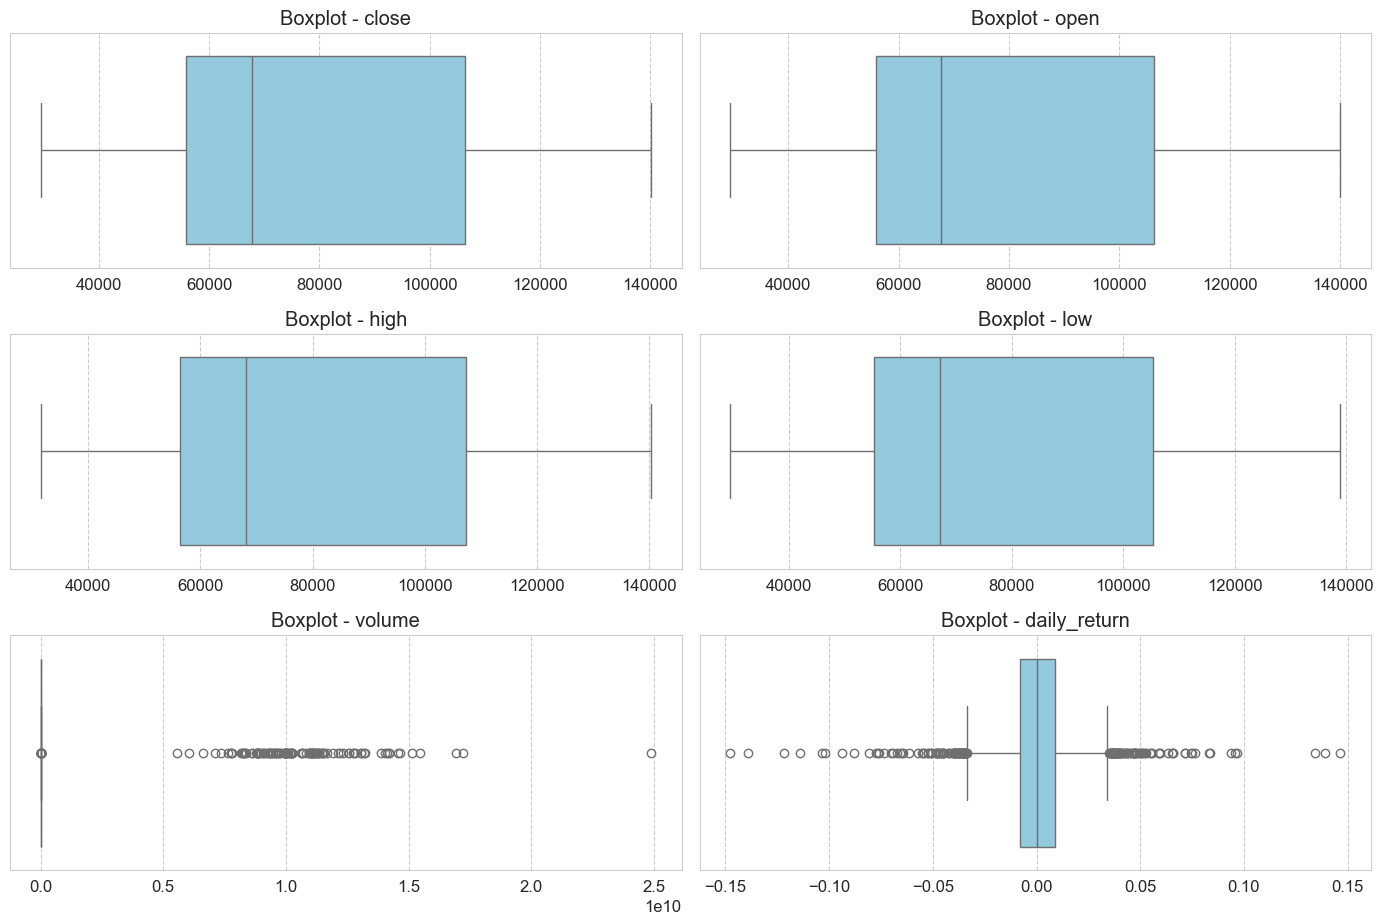

In [19]:
# Box Plots
colunas = df_2015_2025[['close', 'open', 'high', 'low', 'volume', 'daily_return']]

plt.figure(figsize=(14, 18))  # aumenta o tamanho para n√£o ficar apertado

for i, coluna in enumerate(colunas, 1):
    plt.subplot(6, 2, i)
    sns.boxplot(x=df[coluna], color='skyblue')
    plt.title(f'Boxplot - {coluna}')
    plt.xlabel('')
    plt.tight_layout()

#### Tivemos uma distor√ß√£o grande nos dados do volume,  devido a uma abrupta varia√ß√£o na m√©dia de negocia√ß√£o di√°ria, a partir de 07 de Janeiro de 2025 at√© o momento, os valores negociados saltaram da casa de Milh√µes, que vinham sendo mostradas at√© essa data de 7 de Janeiro, para a casa de Bilh√µes a partir dessa data, distorcendo totalmente os dados prejudicando assim futuras an√°lises que seriam feitas com o volume negociado.

#### Os gr√°ficos abaixo monstram o tamanho da distor√ß√£o devido a esse aumento de valores abrupto. Por causa dele n√£o √© possivel obter a leitura do periodo anterior ao in√≠cio desse acontecimento, ao filtrar o periodo para o dia 01/01/2025 observamos que a movimenta√ß√£o do volume √© normalizada.

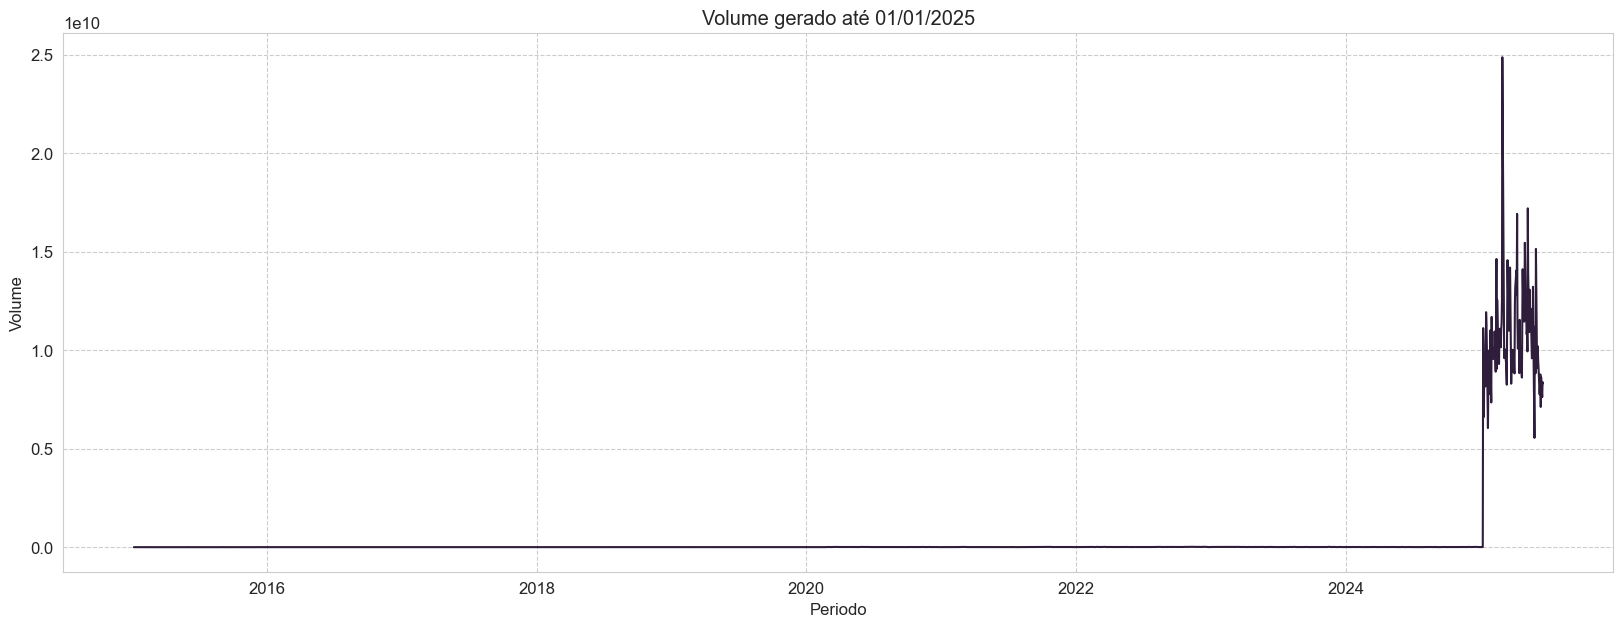

In [48]:
# # Gr√°fico do volume completo
sns.lineplot(df_2015_2025, x=df_2015_2025.index, y='volume',legend=True)
plt.title('Volume gerado at√© 01/01/2025')
plt.xlabel('Periodo')
plt.ylabel('Volume')
plt.show()

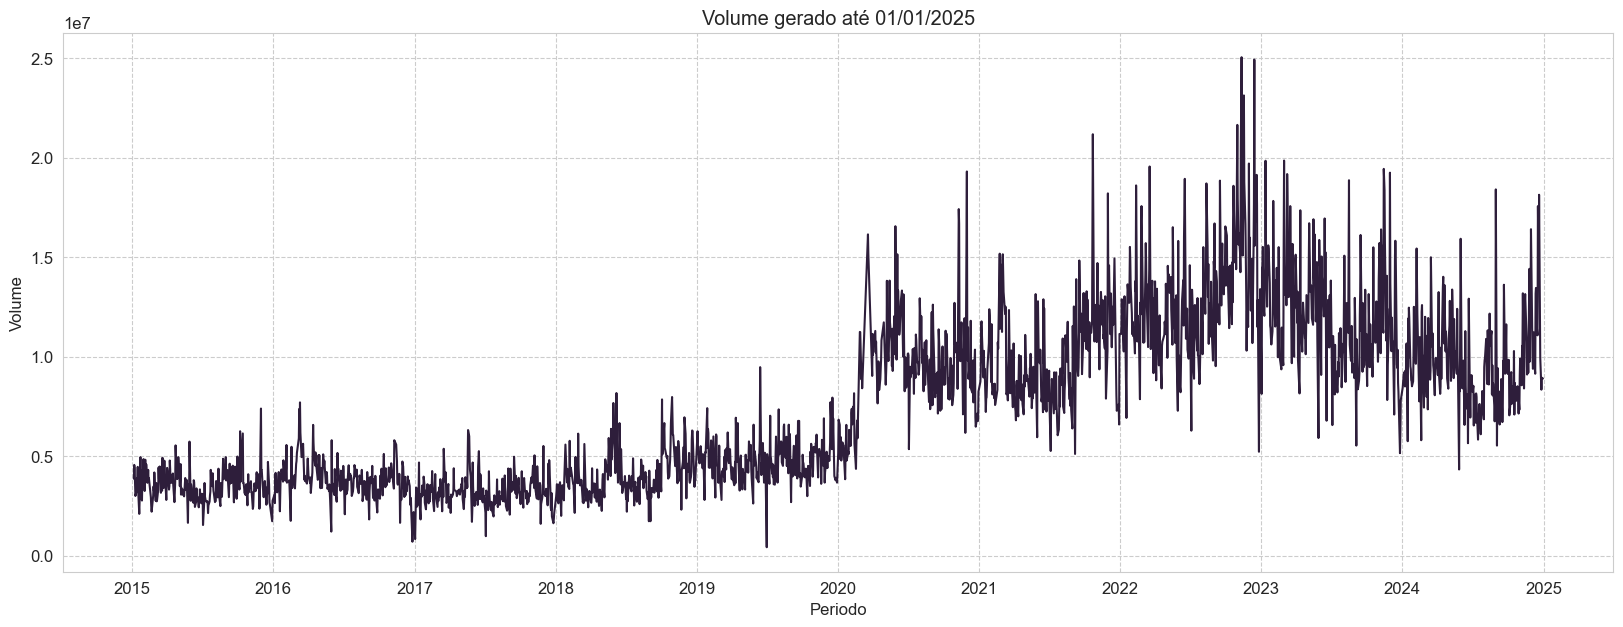

In [47]:
vol = df_2015_2025[df_2015_2025.index < '2025-01-01']
# Gr√°fico do volume com data at√© dia 01-01-2025

sns.lineplot(vol, x=vol.index, y='volume',legend=True)
plt.title('Volume gerado at√© 01/01/2025')
plt.xlabel('Periodo')
plt.ylabel('Volume')
plt.show()

In [20]:
# Z-Score e Intervalo Interquartil (IQR)

colunas = ['close', 'open', 'high', 'low', 'volume', 'daily_return']

for col in colunas:
    print(f'\nüìå Analisando a coluna: {col.upper()}')

    # === Z-SCORE ===
    df_2015_2025[f'z_score_{col}'] = zscore(df_2015_2025[col].dropna())  # evita erro com NaN
    outliers_z = df_2015_2025[(df_2015_2025[f'z_score_{col}'] > 3) | (df_2015_2025[f'z_score_{col}'] < -3)] # 3 vezes acima ou abaixo do desvio padr√£o
    print(f'üîπ Outliers (Z-Score): {len(outliers_z)}')
    print(outliers_z[[col, f'z_score_{col}']].head())

    # === IQR ===
    Q1 = df_2015_2025[col].quantile(0.25)
    Q3 = df_2015_2025[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR # valores abaixo de 1.5 vezes do Intervalo interquartil
    limite_superior = Q3 + 1.5 * IQR # valores acima de 1.5 vezes do Intervalo interquartil

    outliers_iqr = df_2015_2025[(df_2015_2025[col] < limite_inferior) | (df_2015_2025[col] > limite_superior)] # Efetua a condi√ß√£o para definir se √© outlier ou n√£o
    print(f'üî∏ Outliers (IQR): {len(outliers_iqr)}')
    print(outliers_iqr[[col]].head())


üìå Analisando a coluna: CLOSE
üîπ Outliers (Z-Score): 0
Empty DataFrame
Columns: [close, z_score_close]
Index: []
üî∏ Outliers (IQR): 0
Empty DataFrame
Columns: [close]
Index: []

üìå Analisando a coluna: OPEN
üîπ Outliers (Z-Score): 0
Empty DataFrame
Columns: [open, z_score_open]
Index: []
üî∏ Outliers (IQR): 0
Empty DataFrame
Columns: [open]
Index: []

üìå Analisando a coluna: HIGH
üîπ Outliers (Z-Score): 0
Empty DataFrame
Columns: [high, z_score_high]
Index: []
üî∏ Outliers (IQR): 0
Empty DataFrame
Columns: [high]
Index: []

üìå Analisando a coluna: LOW
üîπ Outliers (Z-Score): 0
Empty DataFrame
Columns: [low, z_score_low]
Index: []
üî∏ Outliers (IQR): 0
Empty DataFrame
Columns: [low]
Index: []

üìå Analisando a coluna: VOLUME
üîπ Outliers (Z-Score): 108
                  volume  z_score_volume
ds                                      
2025-01-07  1.112000e+10        4.781699
2025-01-08  1.023000e+10        4.382193
2025-01-10  9.260000e+09        3.946776
2025-01-13  

#### Devido a essa distor√ß√£o significante, fizemos testes Z-SCORE e de Intervalo Interquartil, para observarmos quantos dados est√£o sendo considerados outliers, e assim definir o que poder√° ser feito caso esses outliers venham a nos prejudicar em an√°lises futuras, e quando formos utiliz√°-los nos modelos de Machine Learning.

In [49]:
(df_2015_2025)

target   close    open    high     low        volume  daily_return
ds                                                                            
2015-01-05     0.0   47517   48512   48512   47264  3.870000e+06       -0.0205
2015-01-06     1.0   48001   47517   48061   47338  4.560000e+06        0.0102
2015-01-07     1.0   49463   48006   49882   48006  4.410000e+06        0.0305
2015-01-08     1.0   49943   49463   50261   49017  3.620000e+06        0.0097
2015-01-09     0.0   48840   49955   49955   48501  3.000000e+06       -0.0221
...            ...     ...     ...     ...     ...           ...           ...
2025-06-12     1.0  137800  137127  137931  136175  7.120000e+09        0.0049
2025-06-13     0.0  137213  137800  137800  136586  8.630000e+09       -0.0043
2025-06-16     1.0  139256  137212  139988  137212  7.620000e+09        0.0149
2025-06-17     0.0  138840  139256  139497  138293  8.380000e+09       -0.0030
2025-06-18     0.0  138717  138844  139161  138443  8.320000e+09       -0.0009

[2518 rows x 7 columns]

In [52]:
print(f'Percentual de outlier de IRQ em rela√ß√£o ao df de analise: {round(len(outliers_iqr) / len(df_2015_2025) * 100, 2)}%')
print(f'Percentual de outlier de Z-SCORE em rela√ß√£o ao df de analise: {round(len(outliers_z) / len(df_2015_2025) * 100, 2)}%')
print(f'Percentual de outlier total em rela√ß√£o ao df de analise: {round((len(outliers_z) + len(outliers_iqr)) / len(df_2015_2025) * 100, 2)}%')

Percentual de outlier de IRQ em rela√ß√£o ao df de analise: 2.98%
Percentual de outlier de Z-SCORE em rela√ß√£o ao df de analise: 1.07%
Percentual de outlier total em rela√ß√£o ao df de analise: 4.05%


#### Obtivemos 4.05% de outliers, fazendo uma an√°lise minuciosa dos dados, percebesse que esses outliers est√£o espalhados desde de 2015 at√© 2024 sendo que 1 dia em 2023 e 1 dia em 2024, sendo assim consideramos que a exclus√£o dos dados da coluna daily_return, que acreditamos n√£o afetar√° nosso conjunto de dados para an√°lises posteriores, e tamb√©m para ser utilizado em nossos modelos.

#### Optamos por n√£o utilizar os dados de volume devido a discrep√¢ncia dada desde de 07 Janeiro de 2025, com um varia√ß√£o abrupta da casa de Milh√µes para Bilh√µes distorcendo completamente nossas an√°lises.

In [ ]:
# Unir linhas de outliers a-score e IQR
indices_outliers = outliers_iqr.index.union(outliers_z.index)

# Remove linhas do DataFrame original
df_2015_2025 = df_2015_2025.drop(index=indices_outliers, axis=0).copy()
df_2015_2025 = df_2015_2025.drop(columns= ['z_score_close', 'z_score_open', 'z_score_high', 'z_score_low',
       'z_score_volume', 'z_score_daily_return']).copy()
df_2015_2025

target   close    open    high     low        volume  daily_return
ds                                                                            
2015-01-05     0.0   47517   48512   48512   47264  3.870000e+06       -0.0205
2015-01-06     1.0   48001   47517   48061   47338  4.560000e+06        0.0102
2015-01-07     1.0   49463   48006   49882   48006  4.410000e+06        0.0305
2015-01-08     1.0   49943   49463   50261   49017  3.620000e+06        0.0097
2015-01-09     0.0   48840   49955   49955   48501  3.000000e+06       -0.0221
...            ...     ...     ...     ...     ...           ...           ...
2025-06-12     1.0  137800  137127  137931  136175  7.120000e+09        0.0049
2025-06-13     0.0  137213  137800  137800  136586  8.630000e+09       -0.0043
2025-06-16     1.0  139256  137212  139988  137212  7.620000e+09        0.0149
2025-06-17     0.0  138840  139256  139497  138293  8.380000e+09       -0.0030
2025-06-18     0.0  138717  138844  139161  138443  8.320000e+09       -0.0009

[2518 rows x 7 columns]

## An√°lise Univariada

#### Teste de hip√≥tese

O teste de Shapiro-Wilk √© um teste de hip√≥tese que verifica se uma amostra de dados segue uma distribui√ß√£o normal.

* Hip√≥tese Nula (H‚ÇÄ): A amostra prov√©m de uma popula√ß√£o com distribui√ß√£o normal.
* Hip√≥tese Alternativa (H‚ÇÅ): A amostra N√ÉO prov√©m de uma popula√ß√£o com distribui√ß√£o normal.

Teste curtose, Assim√©trico e D'Agostino.

* Curtose - Descrevendo a forma da cauda de uma distribui√ß√£o normal para observar o qu√£o pesadas ou leves s√£o as extremidades em rela√ß√£o √† m√©dia.
* Assim√©trico - Observa a assimetria das ca√∫das, se menor que 0 assimetria a esquerda, se maior que 0 assimetria a direita e igual ou muito pr√≥ximo de 0 sim√©trica.
* D'Agotino - Teste alternativo ao de normalidade, com o mesmo prop√≥sito, p_value < 0.05, a distribui√ß√£o n√£o √© normal.


üìä An√°lise da coluna: close


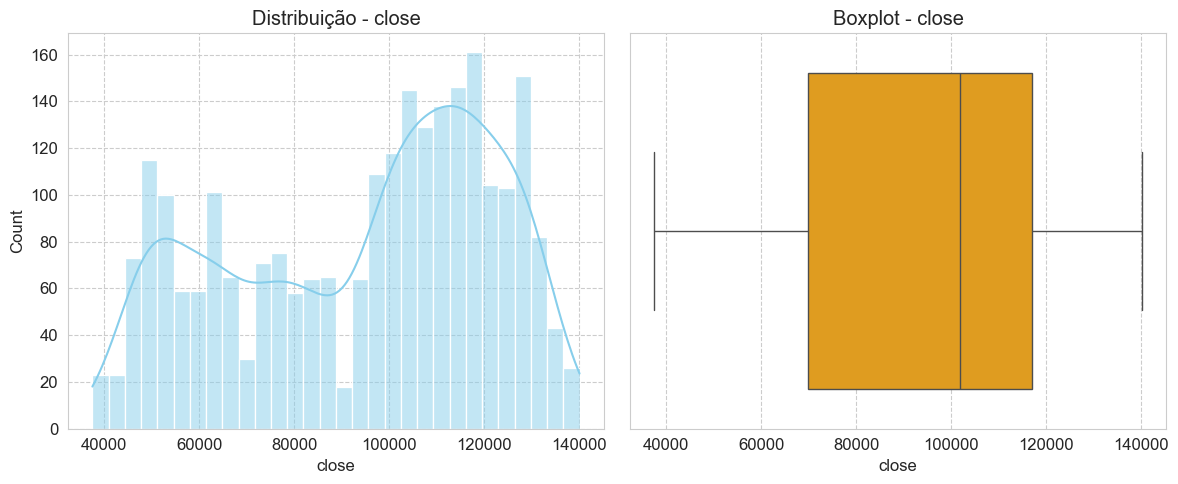

üìà Assimetria: -0.3884
üìâ Curtose: -1.1320
üß™ Shapiro-Wilk p-valor: 0.0000 (n√£o normal)
üß™ D‚ÄôAgostino p-valor: 0.0000 (n√£o normal)

üìä An√°lise da coluna: open


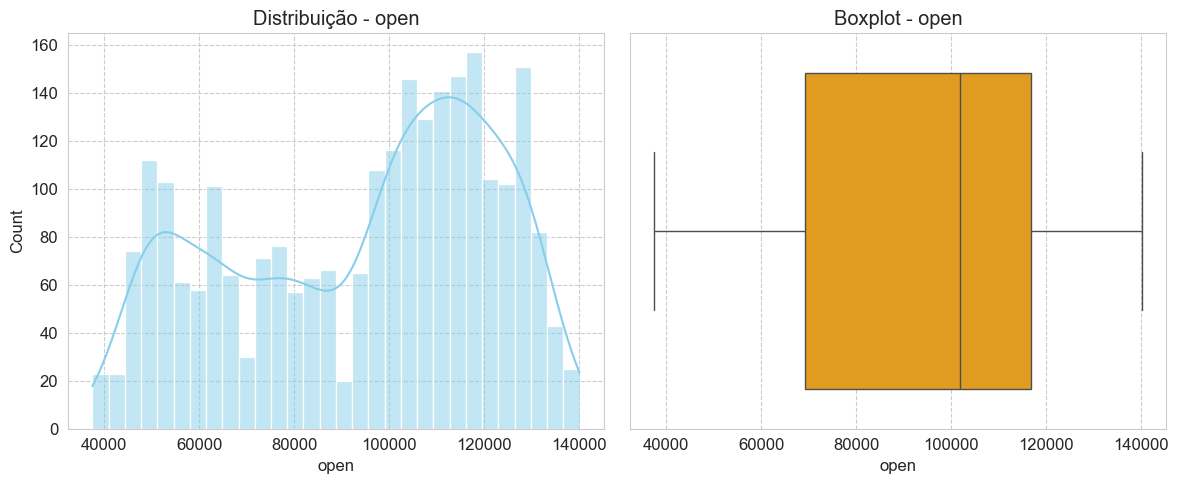

üìà Assimetria: -0.3860
üìâ Curtose: -1.1347
üß™ Shapiro-Wilk p-valor: 0.0000 (n√£o normal)
üß™ D‚ÄôAgostino p-valor: 0.0000 (n√£o normal)

üìä An√°lise da coluna: high


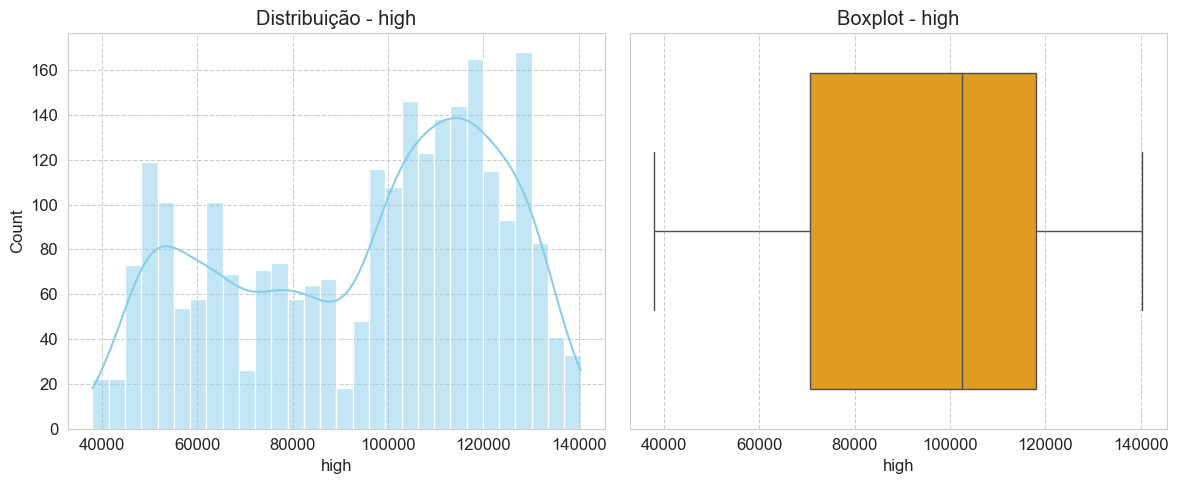

üìà Assimetria: -0.3953
üìâ Curtose: -1.1350
üß™ Shapiro-Wilk p-valor: 0.0000 (n√£o normal)
üß™ D‚ÄôAgostino p-valor: 0.0000 (n√£o normal)

üìä An√°lise da coluna: low


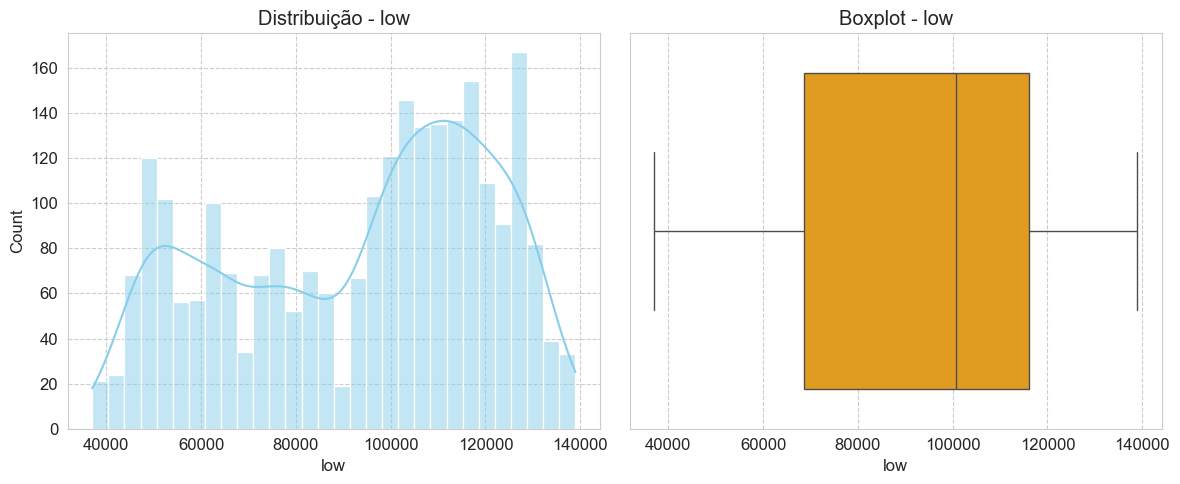

üìà Assimetria: -0.3795
üìâ Curtose: -1.1313
üß™ Shapiro-Wilk p-valor: 0.0000 (n√£o normal)
üß™ D‚ÄôAgostino p-valor: 0.0000 (n√£o normal)

üìä An√°lise da coluna: daily_return


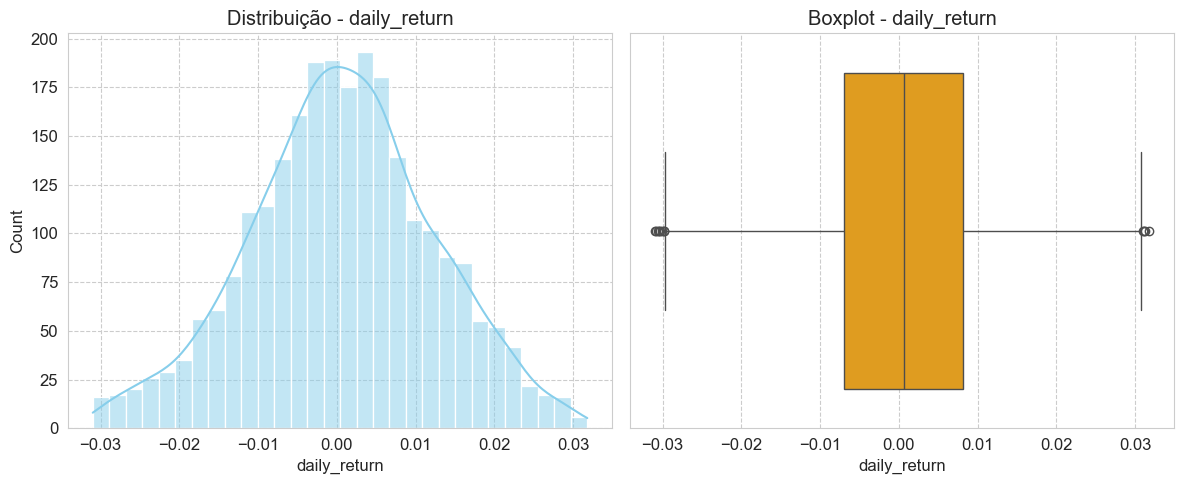

üìà Assimetria: -0.0658
üìâ Curtose: -0.1359
üß™ Shapiro-Wilk p-valor: 0.2480 (normal)
üß™ D‚ÄôAgostino p-valor: 0.1451 (normal)


In [23]:
colunas = ['close', 'open', 'high', 'low', 'daily_return']  # Altere conforme necess√°rio

for coluna in colunas:
    print(f'\nüìä An√°lise da coluna: {coluna}')

    # Plot da distribui√ß√£o
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df_2015_2025[coluna], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribui√ß√£o - {coluna}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_2015_2025[coluna], color='orange')
    plt.title(f'Boxplot - {coluna}')

    plt.tight_layout()
    plt.show()

    # Estat√≠sticas
    assimetria = skew(df_2015_2025[coluna].dropna())
    curtose = kurtosis(df_2015_2025[coluna].dropna(), fisher=True)
    stat_shapiro, p_shapiro = shapiro(df_2015_2025[coluna].dropna().sample(n=500) if df_2015_2025[coluna].dropna().shape[0] > 500 else df_2015_2025[coluna].dropna())
    stat_dagostino, p_dagostino = normaltest(df_2015_2025[coluna].dropna())

    print(f'üìà Assimetria: {assimetria:.4f}') # Observar se a cauda da direita √© > 0 - a da esquerda √© < 0 e se for igual a 0 √© sim√°trica 
    print(f'üìâ Curtose: {curtose:.4f}') # 
    print(f'üß™ Shapiro-Wilk p-valor: {p_shapiro:.4f} {"(n√£o normal)" if p_shapiro < 0.05 else "(normal)"}') # Teste de normalidade p < 0.05 -> n√£o √© normal
    print(f'üß™ D‚ÄôAgostino p-valor: {p_dagostino:.4f} {"(n√£o normal)" if p_dagostino < 0.05 else "(normal)"}') # Teste alternativo de normalidade p < 0.05 -> n√£o √© normal


#### Ao Remover os outliers da varia√ß√£o di√°ria, conseguimos alcan√ßar uma distribui√ß√£o normal dos dados.

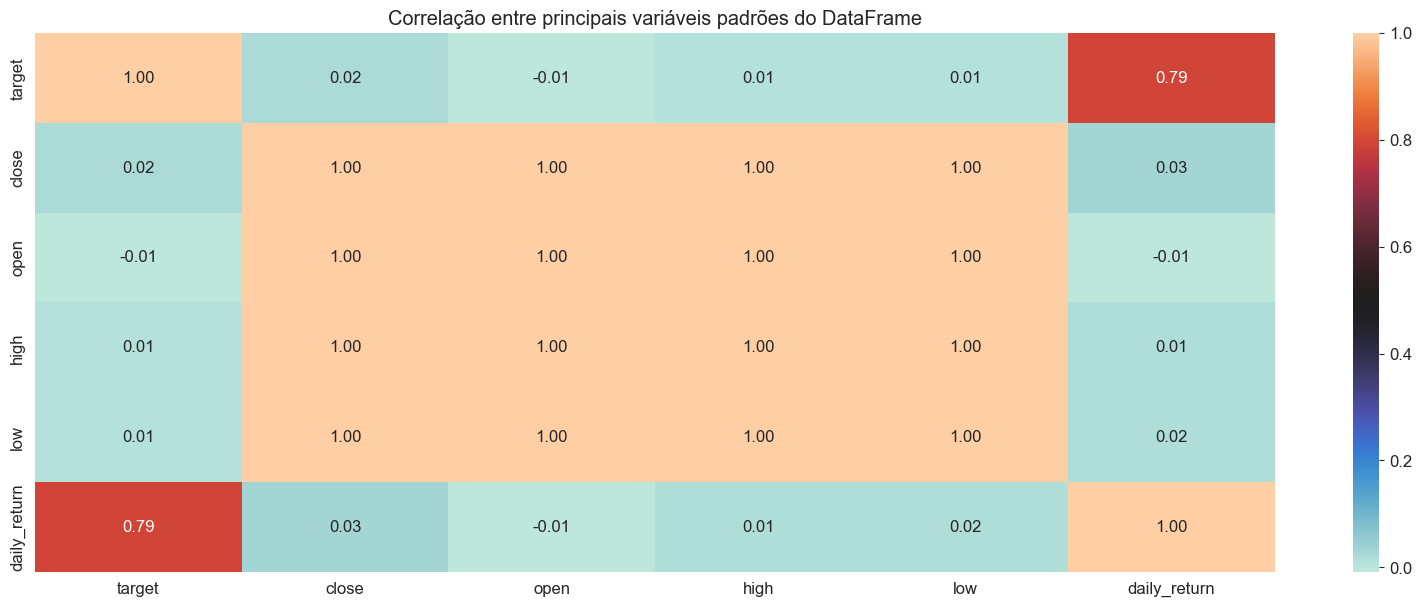

In [ ]:
# Gerando Gr√°fico de correla√ß√£o
corr = df_2015_2025[['target','close', 'open', 'high', 'low', 'daily_return']].corr(numeric_only=True)

sns.heatmap(corr, annot=True, fmt='.2f', center= 0.5)
plt.title('Correla√ß√£o entre principais vari√°veis padr√µes do DataFrame')
plt.show()

#### Observando a correla√ß√£o entre as co-v√°riaveis e nossa vari√°vel resposta, percebemos n√£o ter correla√ß√£o significante para uma escolha de co-vari√°veis, que ser√£o utilizadas em nossos modelos de Machine Learning, com a fun√ß√£o de prever o fechamento positivo ou negativo do dia D+1 (dia seguinte ao vigente).  

# Avalia√ß√£o da Serie temporal dos dados originais.

In [26]:
# Decompor s√©rie temporal
annual_period = 252 # ano do preg√£o
df_decomposed = seasonal_decompose(df_2015_2025['close'], model='multiplicative', period=annual_period)

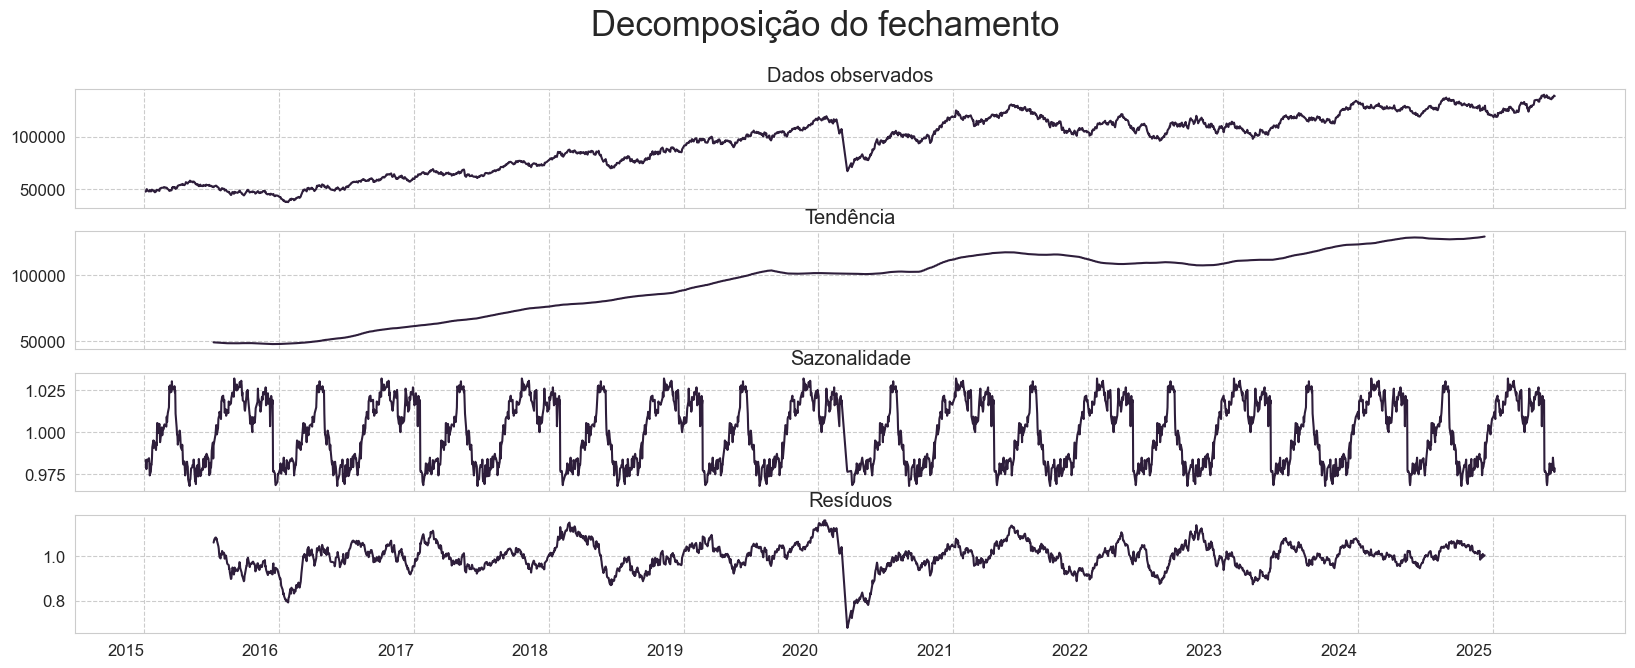

In [27]:
fig, axes = plt.subplots(4, 1, sharex=True,figsize = (20, 8))

df_decomposed.observed.plot(ax = axes[0], title = 'Dados observados')
df_decomposed.trend.plot(ax = axes[1], title = 'Tend√™ncia')
df_decomposed.seasonal.plot(ax = axes[2], title = 'Sazonalidade')
df_decomposed.resid.plot(ax = axes[3], title = 'Res√≠duos')

# T√≠tulo e r√≥tulos dos eixos
fig.suptitle('Decomposi√ß√£o do fechamento')
axes[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.xlabel('')
plt.xticks(rotation='horizontal')

plt.show()

#### Como visto no gr√°fico de decomposi√ß√£o, observamos que o √≠ndice IBOVESPA possui visivelmente uma tend√™ncia de alta que √© logo confirmada pela decomposi√ß√£o TEND√äNCIA, retirando a sazonalidade e o ruido, o IBOVESPA tamb√©m possui uma sazonalidade bem estruturada e constante durante esse periodo de 2015 √† 2025, e por fim os residuos que s√£o as partes que n√£o s√£o possiveis de serem explicadas no gr√°fico, como foram removidos padr√µes de tend√™ncia e sazonalidade dos dados.

#### Estacionaridade

Vamos observar quais dados das duas colunas (close) e (daily_return) possui ou n√£o estacionaridade.

O teste ADF (Augmented Dickey-Fuller) verifica se a s√©rie √© estacionaria, ou seja, como as propriedades mudam ao longo do tempo.

* Hip√≥tese Nula (H‚ÇÄ): A s√©rie N√ÉO √© estacion√°ria (ela possui uma raiz unit√°ria).
* Hip√≥tese Alternativa (H‚ÇÅ): A s√©rie √â estacion√°ria (ela n√£o possui uma raiz unit√°ria).

In [29]:
# Cria fun√ß√£o estacionario
def estacionario(series):

    adf = adfuller(series)
    print(f'Valor-p do Teste ADF: {adf[1]}')

    # N√≠vel de signific√¢ncia de 95%
    if adf[1] > 0.05:
        print('N√£o rejeitar a hip√≥tese nula: a s√©rie N√ÉO √© estacion√°ria')
    else:
        print('Rejeitar a hip√≥tese nula: a s√©rie √© estacion√°ria')

In [ ]:
# Testa dados de fechamento e varia√ß√£o di√°ria
# Fechamento
print('Fechamento')
estacionario(df['close'].values)

print('--------')

# Retorno di√°rio
print('Retorno di√°rio')
estacionario(df['daily_return'].values)

Fechamento
Valor-p do Teste ADF: 0.8539703036576209
N√£o rejeitar a hip√≥tese nula: a s√©rie N√ÉO √© estacion√°ria
--------
Retorno di√°rio
Valor-p do Teste ADF: 0.0
Rejeitar a hip√≥tese nula: a s√©rie √© estacion√°ria


#### Para modelos de Machine Learning de regress√£o, podemos utilizar a daily_return como nossa vari√°vel resposta, porque ela j√° est√° estacion√°ria, e assim as rela√ß√µes de aprendizagem entre as features, e ela poder√° obter mais chances de se manterem v√°lidas no futuro.  
#### Agora caso for necess√°rio utilizar modelos especificos de supervis√£o de s√©ries temporais, que foram explicitamente projetadas para lidar com dados n√£o-estacion√°rios podemos utilizar o fechamento como vari√°vel resposta.

In [31]:
# transforma o close em estacion√°rio
print('Fechamento diferenciado 1x')
estacionario(df['close'].diff().dropna().values)

Fechamento diferenciado 1x
Valor-p do Teste ADF: 0.0
Rejeitar a hip√≥tese nula: a s√©rie √© estacion√°ria


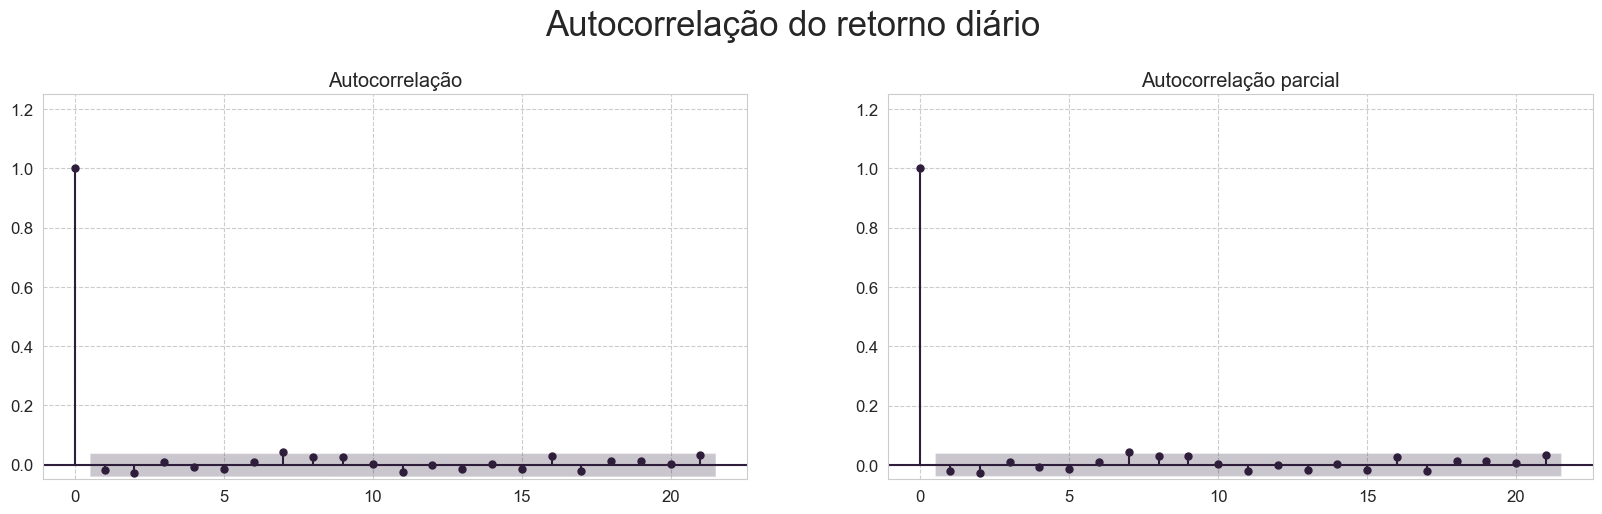

In [ ]:
# Gr√°fico de AUTOCORRELA√á√ÉO
fig, axes = plt.subplots(1, 2, figsize = (20,5))

plot_acf(df_2015_2025['daily_return'], lags = 21, title = 'Autocorrela√ß√£o', auto_ylims = True, ax = axes[0])
plot_pacf(df_2015_2025['daily_return'], lags = 21, title = 'Autocorrela√ß√£o parcial', auto_ylims = True, ax = axes[1])
plt.suptitle('Autocorrela√ß√£o do retorno di√°rio', y=1.05)
plt.show()

#### O gr√°fico de alto correla√ß√£o ACF e PACF nos √≠ndica que fora o lag 1 que √© normal essa alta correla√ß√£o, porque ele fazcorrela√ß√£o com ele mesmo, o restante das correla√ß√µes dentro do n√≠vel de confian√ßa de 95%, n√£o tem correla√ß√£o significativa, nos mostrando que os retornos parecem ser independentes no tempo. Isso √© comum em mercado financeiro, pois os pre√ßos tendem a seguir um passeio aleat√≥rio.

# Conclus√£o: 
#### Por esse motivo ap√≥s uma an√°lise minuciosa de nossos dados, chegamos a conclus√£o que s√≥ os dados pertencentes ao dataframe original n√£o s√£o suficientes, para que possam juntos aos modelos, nos trazerem predi√ß√µes satisfat√≥rias e reais, e tamb√©m retorno de previs√£o positiva, que esteja de acordo com nossa meta de score solicitado no des√°fio.